In [1]:
import re
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from myutils.matplotlib import matplotlib_seaborn_style, matplotlib_svg

matplotlib_seaborn_style()
# matplotlib_svg()

## Базовая реструктуризация данных

## Препроцессинг

In [24]:
data = pd.read_csv('../data/data_raw.csv', parse_dates=['date'], encoding='utf-8')

data.head(2)

,date,days,places,price,num,class,train
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе


In [25]:
data['train'].nunique()

144

### Добавляем данные о поездах

In [26]:
train_data = pd.concat([
    pd.read_csv('../data/train_data_spb_msk.csv'),
    pd.read_csv('../data/train_data_nizh_msk.csv'),
])
train_data.head(2)

,num,departure_time,travel_time
0,001А,23:55,08:00
1,003А,23:30,09:00


In [27]:
def to_timestamp(time: str) -> int:
    hour, minute = time.split(':')
    hour = int(hour)
    minute = int(minute)
    
    # timestamp = (hour * 60 + minute) * 60
    timestamp = hour + minute / 60
        
    return timestamp


train_data['departure_timestamp'] = train_data['departure_time'].apply(to_timestamp)
train_data['arrival_timestamp'] = (train_data['departure_timestamp'] \
    + train_data['travel_time'].apply(to_timestamp)) % 24

train_data.head(2)

,num,departure_time,travel_time,departure_timestamp,arrival_timestamp
0,001А,23:55,08:00,23.916667,7.916667
1,003А,23:30,09:00,23.500000,8.500000


In [28]:
data = data.merge(
    train_data[['num', 'departure_timestamp', 'arrival_timestamp']],
    on='num',
    how='left',
)

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


In [29]:
data.loc[data['departure_timestamp'].isna(), 'num'].unique()

array([], dtype=object)

### Удаляем данные за праздники (29 апреля — 12 мая)

In [30]:
holidays = np.arange(
    datetime(year=2021, month=4, day=29),
    datetime(year=2021, month=5, day=13),
    timedelta(days=1),
)

data = data[~data['date'].isin(holidays)].copy()

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


### Заполненность строк для разных поездов

In [31]:
dates = data['date'].drop_duplicates().sort_values().values

split_id = np.where(dates > holidays[-1])[0][0]

In [32]:
def date_formatter(dt: datetime) -> str:
    return dt.strftime('%b %d (%a)')

In [33]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)

filled_frac.head(2)

,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2021-04-04,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,...,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667


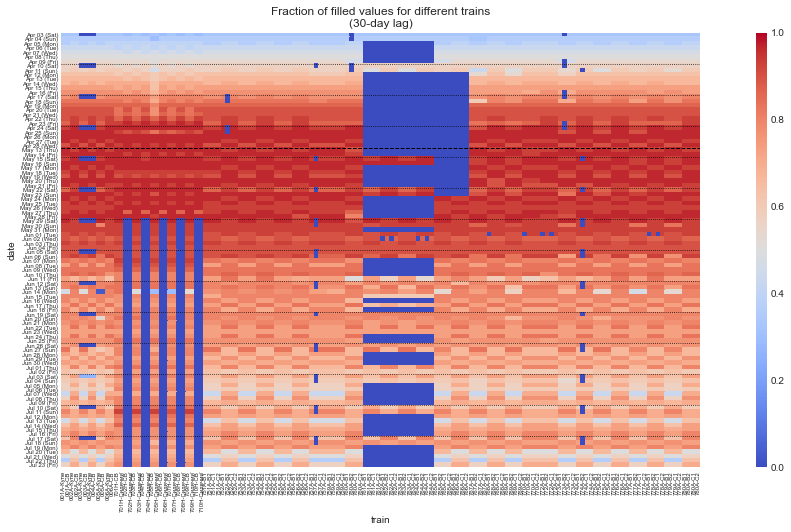

In [34]:
filled_frac_ = filled_frac.copy()
filled_frac_.index = filled_frac_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(filled_frac_, vmin=0, vmax=1, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig('../data/figures/filled_frac.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Удаляем поезда, по которым слишком мало данных

__Важно!__ Надо не забыть, что мы не просто выкидываем данные, а планируем рассмотреть их отдельно, когда данных станет больше.

In [35]:
train_nums_to_remove = ['761А', '762А', '763А', '764А', '765А', '766А', '702Н', '704Н', '706Н', '708Н', '710Н']

mask = data['num'].isin(train_nums_to_remove)
data = data[~mask].copy()

mask.sum(), data['train'].nunique()

(78026, 110)

In [36]:
train_nums_to_remove = ['765А', '766А']
date = datetime(year=2021, month=5, day=24)

mask = (data['num'].isin(train_nums_to_remove) & (data['date'] < date))
data = data[~mask].copy()

mask.sum(), data['train'].nunique()

(0, 110)

In [37]:
filled_frac_melt = filled_frac.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='filled_frac')

filled_frac_melt.head(2)

,date,train,filled_frac
0,2021-04-03,001А-Купе,0.333333
1,2021-04-04,001А-Купе,0.366667


In [38]:
to_remove = filled_frac_melt.loc[filled_frac_melt['filled_frac'] <= 0.6, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

print(to_remove.apply(len).sum())

to_remove.head(2)

3962


train
001А-Купе    [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
001А-СВ      [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
Name: date, dtype: object

In [39]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/144 [00:00<?, ?it/s]

110

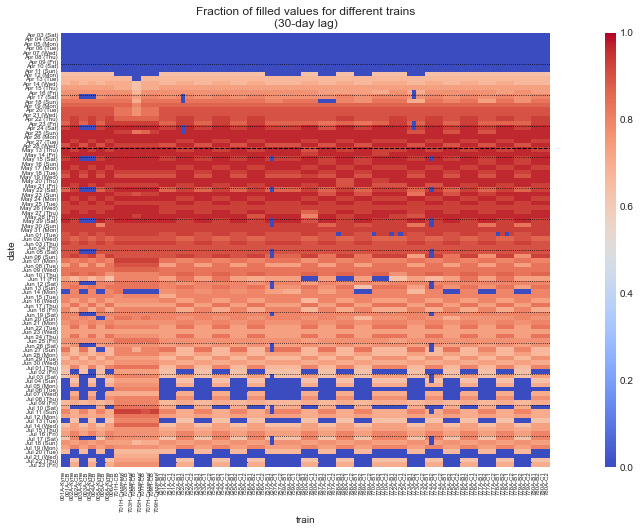

In [40]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(filled_frac, vmin=0, vmax=1, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig('../data/figures/filled_frac_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Вместимость каждого поезда в зависимости от даты

In [41]:
capacity = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity /= capacity.max()

capacity.head(2)

train,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


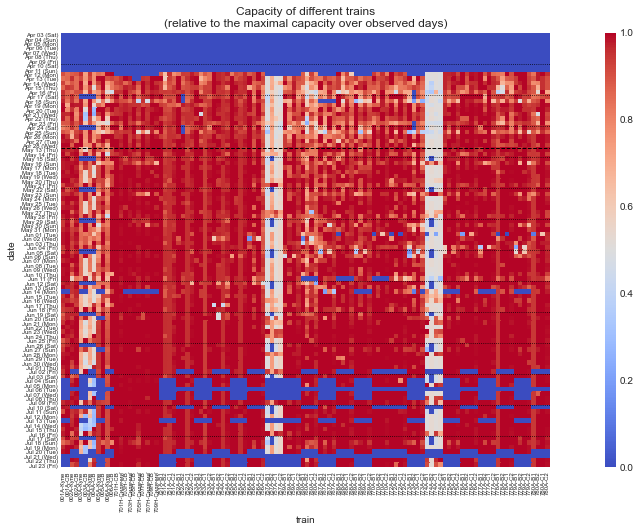

In [42]:
capacity_ = capacity.copy()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(capacity_, ax=ax, square=True, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig('../data/figures/capacity.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Удаляем для некоторых поездов даты, в которые количество вагонов существенно отличается

Белые пятна на картинке выше свидетельствуют о том, что в отдельные дни администрацией РЖД меняется количество вагонов у поезда. Такого рода ситуации надо обрабатывать отдельно. Пока что просто выкидываем.

In [43]:
train_nums_to_remove = ['003А', '004А', '757А', '774А']

mask = data['num'].isin(train_nums_to_remove)

data = data[~mask].copy()

mask.sum()

50887

In [44]:
capacity_melt = capacity.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='capacity')

capacity_melt.head(2)

,date,train,capacity
0,2021-04-03,001А-Купе,0.0
1,2021-04-04,001А-Купе,0.0


In [45]:
to_remove = capacity_melt.loc[capacity_melt['capacity'] <= 0.7, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

print(to_remove.apply(len).sum())

to_remove.head(2)

2651


train
001А-Купе    [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
001А-СВ      [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
Name: date, dtype: object

In [46]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/110 [00:00<?, ?it/s]

98

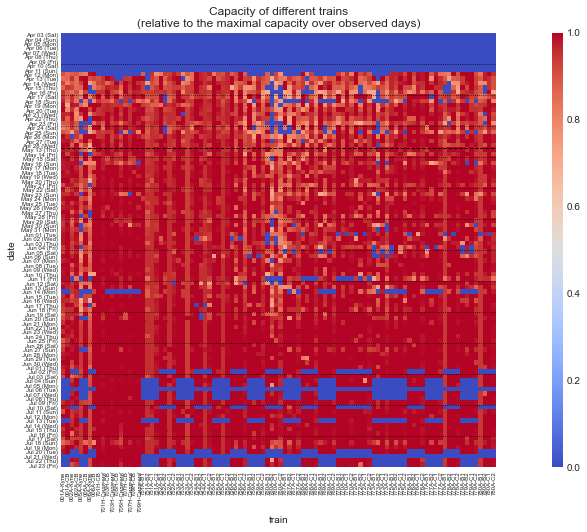

In [47]:
capacity_ = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity_ /= capacity_.max()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(capacity_, ax=ax, square=True, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig('../data/figures/capacity_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [48]:
for train in data['train'].unique():
    mask = data['train'] == train
    data.loc[mask, 'places_frac'] = data.loc[mask, 'places'] / data.loc[mask, 'places'].max()
    
data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,places_frac
9,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000
10,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429


### Данные по дням недели

In [27]:
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

weekdays

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [28]:
trains = data['train'].drop_duplicates().sort_values().values
len(trains)

116

In [29]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_weekday.pdf', transparent=True, bbox_inches='tight')
plt.close()

Несколько быстрых точечных исправлений (очевидные ошибки при сборе данных).

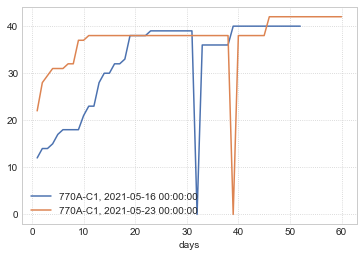

In [30]:
train = '770А-C1'

for date, days in [
    (datetime(year=2021, month=5, day=16), 32),
    (datetime(year=2021, month=5, day=23), 39),
]:
    data[(data['train'] == train) & (data['date'] == date)]\
        .set_index('days')['places'].plot(label=f'{train}, {date}')

    mask = (data['train'] == train)\
        & (data['date'] == date)\
        & (data['days'] == days)

    data.loc[mask, 'places'] = np.nan
        
plt.legend()

In [31]:
data = data.dropna(subset=['places', 'price'], how='all')

Есть несколько поездов, в которых число вагонов явно увеличивалось извне (т.е. со стороны РЖД) в ходе приближения даты отправления. Такие поезда пока выкидываем, потому что это особенность, с которой пока не ясно, как работать.

In [32]:
trains_to_remove = ['001А-СВ', '002А-СВ', '005А-Купе', '006А-Купе']

data = data[~data['train'].isin(trains_to_remove)].copy()

In [33]:
trains = data['train'].drop_duplicates().sort_values().values
len(trains)

112

Максимум модуля разности между соседними значениями вектора за поезд-день. Если значение больше 0.45 (т.е. за день было скуплено/возвращено более 45% мест), то это подозрение на выброс.

In [34]:
max_step = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    max_step[train] = (places_frac - places_frac.shift(axis=1)).abs().max(axis=1)
    
max_step = pd.DataFrame(max_step).reindex(dates)

max_step.tail(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,702Н-СВ,702Н-Сидячий,703Н-СВ,703Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-06-29,0.064286,0.041667,0.107143,0.071429,0.095238,0.062678,NaN,NaN,0.142857,0.048433,...,0.045455,0.040541,0.117647,0.122449,0.113636,0.067568,0.111111,0.102041,0.113636,0.035135
2021-06-30,0.050000,0.062500,0.142857,0.142857,0.142857,0.094017,NaN,NaN,0.142857,0.096866,...,0.045455,0.070270,0.058824,0.122449,0.113636,0.075676,0.166667,0.265306,0.113636,0.108108


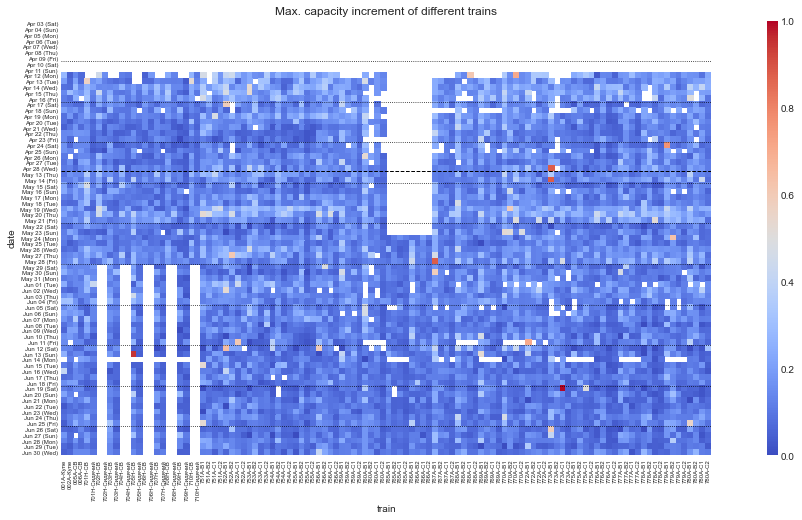

In [35]:
max_step_ = max_step.copy()
max_step_.index = max_step_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(max_step_, ax=ax, vmin=0, vmax=1, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, max_step_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Max. capacity increment of different trains')

plt.savefig('../data/figures/max_capacity_increment.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [36]:
max_step_melt = max_step.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='max_step')

max_step_melt.head(2)

,date,train,max_step
0,2021-04-03,001А-Купе,NaN
1,2021-04-04,001А-Купе,NaN


In [37]:
to_remove = max_step_melt.loc[max_step_melt['max_step'] >= 0.45, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

to_remove.head(2)

train
701Н-СВ    [2021-04-13T00:00:00.000000000, 2021-05-15T00:...
702Н-СВ    [2021-04-12T00:00:00.000000000, 2021-05-19T00:...
Name: date, dtype: object

In [38]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/35 [00:00<?, ?it/s]

112

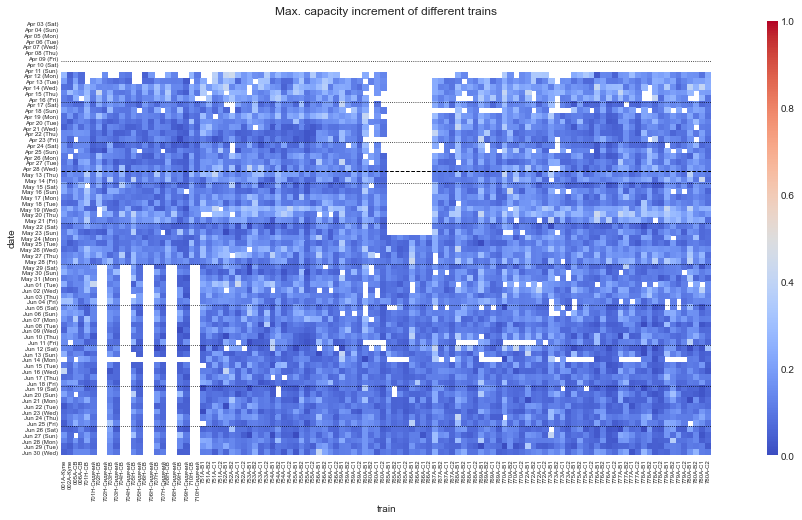

In [39]:
max_step_ = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    max_step_[train] = (places_frac - places_frac.shift(axis=1)).abs().max(axis=1)
    
max_step_ = pd.DataFrame(max_step_).reindex(dates)

max_step_.index = max_step_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(max_step_, ax=ax, vmin=0, vmax=1, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, max_step_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Max. capacity increment of different trains')

plt.savefig('../data/figures/max_capacity_increment_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [40]:
trains = data['train'].unique().tolist()

len(trains)

112

In [41]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_weekday_interm.pdf', transparent=True, bbox_inches='tight')
plt.close()

Ручным образом удаляем малочисленные "нижние" выбросы.

In [42]:
capacity_deviations = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    places_frac = (places_frac - places_frac.median()).mean(axis=1)
    capacity_deviations[train] = places_frac
    
capacity_deviations = pd.DataFrame(capacity_deviations).reindex(dates)

capacity_deviations.tail(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,702Н-СВ,702Н-Сидячий,703Н-СВ,703Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-06-29,0.026419,0.032375,0.015900,0.071680,0.009242,0.017469,NaN,NaN,-0.079887,-0.001331,...,0.021287,0.027541,0.034649,0.046408,-0.021793,0.000037,0.021518,0.009054,-0.020166,0.038371
2021-06-30,-0.022016,-0.081364,-0.032045,0.067697,0.024273,0.025604,NaN,NaN,0.030921,0.013339,...,0.026967,0.019080,0.023368,-0.098127,0.018369,-0.002147,0.022803,0.064423,0.025441,0.030758


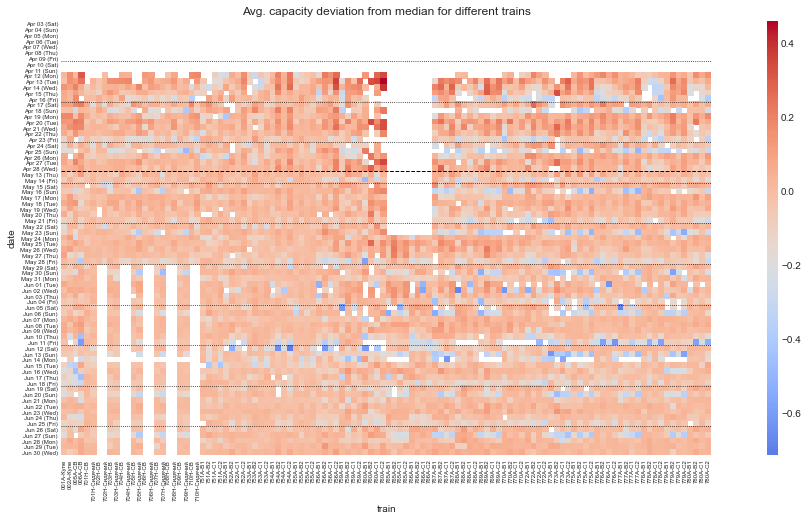

In [43]:
capacity_deviations_ = capacity_deviations.copy()
capacity_deviations_.index = capacity_deviations_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(capacity_deviations_, ax=ax, center=-0.2, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_deviations_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Avg. capacity deviation from median for different trains')

plt.savefig('../data/figures/capacity_deviations.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [44]:
number_of_outliers = dict.fromkeys(trains, 0)

number_of_outliers['001А-Купе'] = 1
number_of_outliers['002А-Купе'] = 1
number_of_outliers['703Н-Сидячий'] = 3
number_of_outliers['708Н-Сидячий'] = 2
number_of_outliers['751А-B2'] = 1
number_of_outliers['751А-C2'] = 1
number_of_outliers['752А-B2'] = 3
number_of_outliers['752А-C1'] = 2
number_of_outliers['752А-C2'] = 1
number_of_outliers['753А-B2'] = 3
number_of_outliers['753А-C2'] = 5
number_of_outliers['754А-B1'] = 3
number_of_outliers['754А-B2'] = 2
number_of_outliers['754А-C1'] = 3
number_of_outliers['754А-C2'] = 2
number_of_outliers['755А-B1'] = 2
number_of_outliers['755А-B2'] = 2
number_of_outliers['755А-C1'] = 1
number_of_outliers['755А-C2'] = 3
number_of_outliers['756А-B1'] = 4
number_of_outliers['756А-B2'] = 3
number_of_outliers['756А-C1'] = 3
number_of_outliers['759А-B1'] = 1
number_of_outliers['759А-B2'] = 1
number_of_outliers['759А-C1'] = 3
number_of_outliers['759А-C2'] = 1
number_of_outliers['760А-B1'] = 4
number_of_outliers['760А-C1'] = 1
number_of_outliers['765А-B1'] = 2
number_of_outliers['765А-C1'] = 1
number_of_outliers['766А-B1'] = 1
number_of_outliers['766А-B2'] = 3
number_of_outliers['766А-C1'] = 2
number_of_outliers['766А-C2'] = 2
# number_of_outliers['767А-B1'] = 2
number_of_outliers['767А-C1'] = 1
number_of_outliers['768А-B1'] = 1
number_of_outliers['768А-B2'] = 1
number_of_outliers['768А-C1'] = 3
# number_of_outliers['768А-C2'] = 1
number_of_outliers['770А-B1'] = 1
number_of_outliers['770А-B2'] = 1
number_of_outliers['770А-C1'] = 1
number_of_outliers['772А-B1'] = 2
number_of_outliers['772А-C1'] = 3
number_of_outliers['773А-B1'] = 3
number_of_outliers['773А-B2'] = 1
number_of_outliers['773А-C1'] = 2
number_of_outliers['775А-C1'] = 2
number_of_outliers['776А-B2'] = 1
number_of_outliers['776А-C1'] = 2
number_of_outliers['776А-C2'] = 1
number_of_outliers['777А-B1'] = 1
number_of_outliers['777А-C1'] = 1
number_of_outliers['778А-B2'] = 2
number_of_outliers['778А-C1'] = 2
number_of_outliers['778А-C2'] = 1
number_of_outliers['780А-B2'] = 1
number_of_outliers['780А-C1'] = 1
number_of_outliers['780А-C2'] = 1

In [45]:
for train, n in tqdm(number_of_outliers.items()):
    if n == 0:
        continue
    
    deviations = capacity_deviations[train].copy().sort_values(ascending=True)
    dates_to_remove = deviations.index[:n]
    
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

  0%|          | 0/112 [00:00<?, ?it/s]

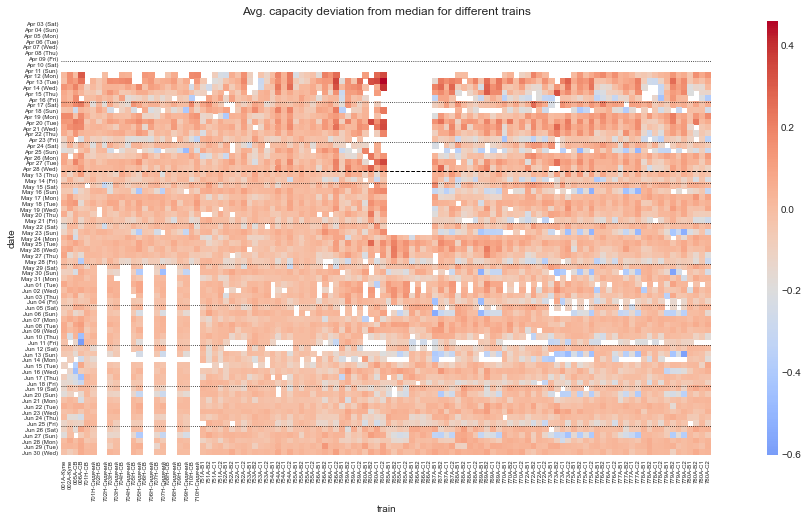

In [46]:
capacity_deviations_ = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    places_frac = (places_frac - places_frac.median()).mean(axis=1)
    capacity_deviations_[train] = places_frac
    
capacity_deviations_ = pd.DataFrame(capacity_deviations_).reindex(dates)
capacity_deviations_.index = capacity_deviations_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(capacity_deviations_, ax=ax, center=-0.2, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_deviations_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Avg. capacity deviation from median for different trains')

plt.savefig('../data/figures/capacity_deviations_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [47]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_weekday_clean.pdf', transparent=True, bbox_inches='tight')
plt.close()

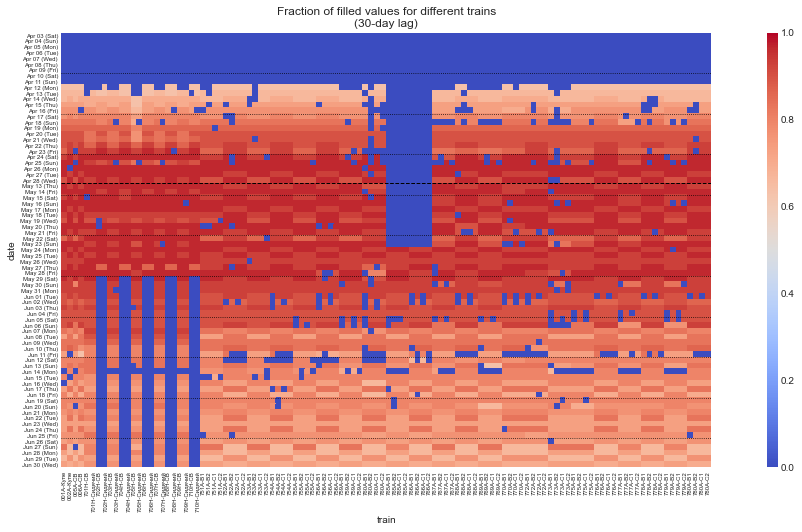

In [48]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(filled_frac, vmin=0, vmax=1, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig('../data/figures/filled_frac_final.pdf', transparent=True, bbox_inches='tight')
# plt.close()

***

In [51]:
data.to_csv('../data/data.csv', index=False, encoding='utf-8')

In [52]:
!jupyter nbconvert --to html 1_preprocessing_eda.ipynb

[NbConvertApp] Converting notebook 1_preprocessing_eda.ipynb to html
[NbConvertApp] Writing 1735060 bytes to 1_preprocessing_eda.html
